In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [2]:
data = pd.read_csv("emails.csv")

<AxesSubplot:>

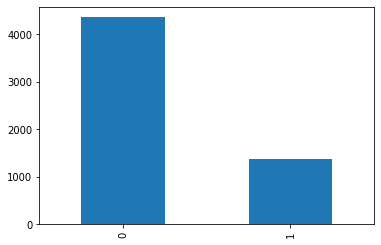

In [3]:
data['spam'].value_counts().plot(kind='bar')

The data contains more than twice the amount of nonspam than spam

preprocessing the data

In [4]:
prep_data=data
#to lower case
prep_data['text']=prep_data['text'].apply(str.lower)

#remove urls
def remove_urls(text):
  # Use a regular expression to match URLs
  pattern = r'((?:http|ftp)s?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)'
  return re.sub(pattern, '', text)

prep_data['text']=prep_data['text'].apply(remove_urls)
#remove digits and special chars
prep_data['text']=prep_data['text'].replace(["\W","\s","\d"],' ',regex=True)




In [5]:
#remove stopwords


stop =set(stopwords.words('english'))
prep_data['text'] = prep_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [6]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True) 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(prep_data['text'])
tfidf_vectorizer_vectors

<5728x33545 sparse matrix of type '<class 'numpy.float64'>'
	with 502705 stored elements in Compressed Sparse Row format>

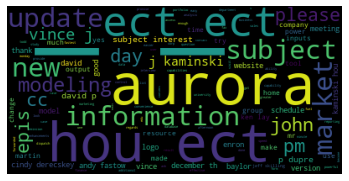

In [7]:
# wordcloud of the complete dataset
wc_input = prep_data['text'].values

wc = WordCloud().generate(str( wc_input ))
plt.imshow(wc)
plt.axis("off")
plt.show()

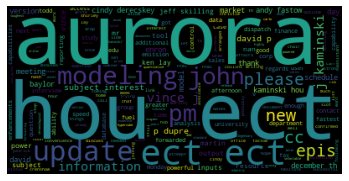

In [8]:
#wordcloud of nonspam data
wc = WordCloud().generate(str( prep_data['text'].where(cond=prep_data['spam']==0).values ))
plt.imshow(wc)
plt.axis("off")
plt.show()

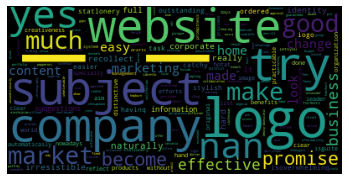

In [9]:
# wordcloud of spamdata
wc = WordCloud().generate(str( prep_data['text'].where(cond=prep_data['spam']==1).values ))
plt.imshow(wc)
plt.axis("off")
plt.show()

The nonspam wordcloud looks more like the wordcloud of the full dataset likely do to  the nonspammail makeing up 2/3 of the dataset.



In [10]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectorizer_vectors,prep_data['spam'], test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4582, 33545) (4582,)
(1146, 33545) (1146,)


In [11]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
lm.score(X_test,y_test)

0.8606331230550534

In [12]:
clf = SVC(kernel='linear').fit(X_train, y_train)
clf.score(X_test,y_test)

0.993891797556719

SVC showed a substancialy higher accuracy than Linear Regression 